### MNIST Digits Generation using DCGAN

In [22]:
### Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import glob # to find certain directories
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import os # to access the folders and files
from keras.utils import plot_model

#### Load the MNIST Dataset

In [23]:
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

#### Visualise a sample image

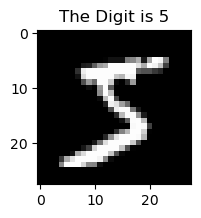

In [24]:
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.title(f"The Digit is {train_labels[0]}")
plt.show()

### Data Preprocessing

In [25]:
BUFFER_SIZE = 60000
BATCH_SIZE = 2048
NOISE_DIM = 100

#### Normalizaation of Images between -1 and 1

In [26]:
train_dataset = (train_images/127.5) - 1.0

#### Resize Images to (32,32)

In [27]:
from skimage.transform import resize
train_images = np.zeros((BUFFER_SIZE,32,32))
for index,img in enumerate(train_dataset):
    train_images[index,:,:] = resize(image=img,output_shape=(32,32))

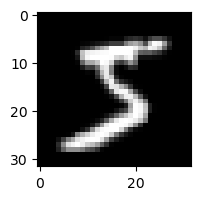

In [28]:
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.show()

In [29]:
train_images.shape

(60000, 32, 32)

#### Reshape Image to add channel dimension

In [30]:
train_images = train_images.reshape(train_images.shape[0],32,32,1).astype('float32')

#### Shuffle the data and store in Batches

In [31]:
# tf.data.Dataset.from_tensor_slices(train_imgaes).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)
# tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)
# tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)
# tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)

In [33]:
sample = next(iter(train_dataset))

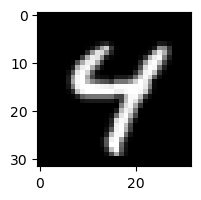

In [38]:
plt.figure(figsize=(2,2))
plt.imshow(sample[0].numpy()[:,:,0],cmap="gray")
plt.show()

### Model Building

#### Generator Model Building

In [42]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*128,use_bias=False,input_shape=(NOISE_DIM,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4,4,128)))

    model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding="same",activation="tanh"))

    return model

In [44]:
generator = make_generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 2048)              204800    
                                                                 
 batch_normalization_9 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 8, 8, 128)        

#### Creating an image using the created generated model

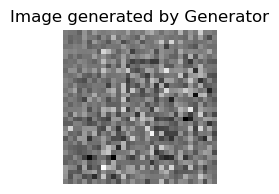

In [46]:
constant_noise = tf.random.normal([1,NOISE_DIM])
generated_image = generator(constant_noise,training=False)

plt.figure(figsize=(2,2))
plt.imshow(generated_image[0,:,:,0],cmap="gray")
plt.title("Image generated by Generator")
plt.axis("off")
plt.show()

#### Building Discriminator Model

In [49]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16,(3,3),strides=(1,1),use_bias=False,input_shape=[32,32,1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32,(3,3),strides=(1,1),use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, (10, 10), strides=(1, 1)))

    model.add(tf.keras.layers.Flatten())
    return model    

In [50]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        144       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 30, 30, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        4608      
                                                                 
 batch_normalization_12 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        18432     
                                                      

In [51]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0006401]], dtype=float32)>

### Model Training


1.   Loss Type
2.   Discriminator Loss
3.   Generator Loss
4.   Optimizer
5.   Checkpoint Initialization
6.   Training Flow



#### Declare Binary Cross Entropy Loss

In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Calculating Discriminator Loss

In [53]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    return real_loss+fake_loss

In [54]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

#### Using Adam Optimizer

In [55]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [56]:
EPOCHS=250

In [59]:
if not os.path.isdir("generated_images"):
    os.mkdir("generated_images")

checkpoint_dir = "./training_checkpoints"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_dir,max_to_keep=3)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

### Training Flow

In [60]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

### Train the DCGAN Model for several Epochs

In [61]:
num_examples_to_generate = 16
seed = tf.random.normal((num_examples_to_generate,NOISE_DIM))

In [ ]:
for epoch in range(1,EPOCHS+1):
    for image_batch in train_dataset:
        train_step(image_batch)

    display.clear_output(wait=True)
    predictions = generator(seed, training= False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap="gray")
        plt.axis("off")